In [1]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

In [2]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import transforms, utils
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)
from torch.distributions import Bernoulli
binarization = lambda x: torch.bernoulli(x)
c_transform  = transforms.Compose([flatten,binarization])

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=c_transform, download=True)
dset_test  = MNIST("./", train=False, transform=c_transform)

# The digit classes to use
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

batch_size = 64
eval_batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


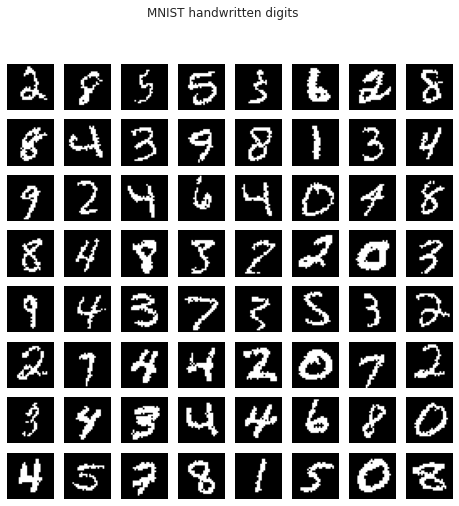

In [3]:
#plot a few MNIST examples
f, axarr = plt.subplots(8, 8, figsize=(8, 8))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
from torch import nn
class Net(nn.Module):
    def __init__(self, input_shape:torch.Size) -> None:
      super(Net, self).__init__()
      self.input_shape = input_shape
      self.observation_features = np.prod(input_shape)
      hidden_sizes = [512, 128, 64]

      # Classifier
      self.classifier = nn.Sequential(
        nn.Dropout(p=0.2),  
        nn.Linear(self.observation_features, hidden_sizes[0]),
        nn.BatchNorm1d(hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.BatchNorm1d(hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1], hidden_sizes[2]),
        nn.BatchNorm1d(hidden_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[2], 10),
      )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y = self.classifier(x)
        return y
      
net = Net(images[0].shape)
print(net)

Net(
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [6]:
net = Net(images[0].shape)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
net = net.to(device)

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device) #torch.nn.functional.one_hot(y)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        i = i+1

    # print statistics
        running_loss += loss.item()
        if i % 400 == 399: # print every 400 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/400))
            running_loss = 0.0

>> Using device: cuda:0
[1,   400] loss: 2.129
[1,   800] loss: 0.946
[2,   400] loss: 0.649
[2,   800] loss: 0.549
[3,   400] loss: 0.455
[3,   800] loss: 0.418
[4,   400] loss: 0.380
[4,   800] loss: 0.360
[5,   400] loss: 0.322
[5,   800] loss: 0.309
[6,   400] loss: 0.283
[6,   800] loss: 0.273
[7,   400] loss: 0.262
[7,   800] loss: 0.255
[8,   400] loss: 0.229
[8,   800] loss: 0.237
[9,   400] loss: 0.221
[9,   800] loss: 0.223
[10,   400] loss: 0.202
[10,   800] loss: 0.204
[11,   400] loss: 0.197
[11,   800] loss: 0.194
[12,   400] loss: 0.189
[12,   800] loss: 0.184
[13,   400] loss: 0.183
[13,   800] loss: 0.181
[14,   400] loss: 0.173
[14,   800] loss: 0.169
[15,   400] loss: 0.158
[15,   800] loss: 0.160
[16,   400] loss: 0.153
[16,   800] loss: 0.156
[17,   400] loss: 0.151
[17,   800] loss: 0.154
[18,   400] loss: 0.141
[18,   800] loss: 0.149
[19,   400] loss: 0.146
[19,   800] loss: 0.137
[20,   400] loss: 0.132
[20,   800] loss: 0.136
[21,   400] loss: 0.127
[21,   800

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
path = "drive//My Drive/Vae/baseline_model_full.pt"
torch.save(net, path)
path = "drive//My Drive/Vae/baseline_model_full.pth"
torch.save(net, path)

In [11]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    x = images.to(device)      
    output = net(x)
    output = output.to('cpu').detach()
    _, predicted = torch.max(output, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 97.660000 %


In [12]:
r_images = torch.load("drive//My Drive/Vae/r_images.pt")
r_labels = torch.load("drive//My Drive/Vae/r_labels.pt")

In [13]:
import random

r_labels = r_labels.type(torch.LongTensor)
net = Net(images[0].shape)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(100):
  running_loss = 0
  for j in range(50):
    randomlist = []
    for i in range(0,99):
      n = random.randint(0,99)
      randomlist.append(n)
    images = r_images[randomlist,]       
    labels = r_labels[randomlist] 

    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss) )

[0] loss: 80.426
[1] loss: 45.036
[2] loss: 27.453
[3] loss: 17.570
[4] loss: 12.100
[5] loss: 8.810
[6] loss: 6.953
[7] loss: 5.519
[8] loss: 4.626
[9] loss: 3.975
[10] loss: 3.523
[11] loss: 3.027
[12] loss: 2.689
[13] loss: 2.476
[14] loss: 2.261
[15] loss: 1.980
[16] loss: 1.892
[17] loss: 1.762
[18] loss: 1.695
[19] loss: 1.544
[20] loss: 1.420
[21] loss: 1.421
[22] loss: 1.257
[23] loss: 1.215
[24] loss: 1.155
[25] loss: 1.112
[26] loss: 1.050
[27] loss: 1.028
[28] loss: 0.998
[29] loss: 0.899
[30] loss: 0.869
[31] loss: 0.856
[32] loss: 0.846
[33] loss: 0.801
[34] loss: 0.771
[35] loss: 0.740
[36] loss: 0.717
[37] loss: 0.670
[38] loss: 0.681
[39] loss: 0.644
[40] loss: 0.618
[41] loss: 0.645
[42] loss: 0.610
[43] loss: 0.598
[44] loss: 0.572
[45] loss: 0.591
[46] loss: 0.516
[47] loss: 0.516
[48] loss: 0.511
[49] loss: 0.501
[50] loss: 0.489
[51] loss: 0.486
[52] loss: 0.458
[53] loss: 0.446
[54] loss: 0.432
[55] loss: 0.439
[56] loss: 0.422
[57] loss: 0.401
[58] loss: 0.452
[5

In [14]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data    
    output = net(images)
    _, predicted = torch.max(output, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 71.290000 %


In [15]:
path = "drive//My Drive/Vae/baseline_model_100.pt"
torch.save(net, path)
path = "drive//My Drive/Vae/baseline_model_100.pth"
torch.save(net, path)

Linear Classifier

In [16]:
from torch import nn
class Net(nn.Module):
    def __init__(self, input_shape:torch.Size) -> None:
      super(Net, self).__init__()
      self.input_shape = input_shape
      self.observation_features = np.prod(input_shape)
      hidden_sizes = [512, 128, 64]

      # Classifier
      self.classifier = nn.Sequential(
        nn.Linear(self.observation_features, 10),
      )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y = self.classifier(x)
        return y
      
net = Net(images[0].shape)
print(net)

Net(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [22]:
net = Net(images[0].shape)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
net = net.to(device)

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device) #torch.nn.functional.one_hot(y)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        i = i+1

    # print statistics
        running_loss += loss.item()
        if i % 400 == 399: # print every 400 mini-batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/400))
            running_loss = 0.0

>> Using device: cuda:0
[1,   400] loss: 2.714
[1,   800] loss: 1.544
[2,   400] loss: 1.208
[2,   800] loss: 1.098
[3,   400] loss: 1.013
[3,   800] loss: 0.953
[4,   400] loss: 0.914
[4,   800] loss: 0.916
[5,   400] loss: 0.863
[5,   800] loss: 0.869
[6,   400] loss: 0.842
[6,   800] loss: 0.818
[7,   400] loss: 0.794
[7,   800] loss: 0.820
[8,   400] loss: 0.792
[8,   800] loss: 0.788
[9,   400] loss: 0.775
[9,   800] loss: 0.763
[10,   400] loss: 0.760
[10,   800] loss: 0.760
[11,   400] loss: 0.748
[11,   800] loss: 0.737
[12,   400] loss: 0.735
[12,   800] loss: 0.740
[13,   400] loss: 0.732
[13,   800] loss: 0.730
[14,   400] loss: 0.704
[14,   800] loss: 0.732
[15,   400] loss: 0.705
[15,   800] loss: 0.725
[16,   400] loss: 0.717
[16,   800] loss: 0.707
[17,   400] loss: 0.703
[17,   800] loss: 0.703
[18,   400] loss: 0.702
[18,   800] loss: 0.698
[19,   400] loss: 0.703
[19,   800] loss: 0.692
[20,   400] loss: 0.698
[20,   800] loss: 0.688
[21,   400] loss: 0.693
[21,   800

In [23]:
path = "drive//My Drive/Vae/baseline_lc_model_full.pt"
torch.save(net, path)
path = "drive//My Drive/Vae/baseline_lc_model_full.pth"
torch.save(net, path)

In [24]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    x = images.to(device)      
    output = net(x)
    output = output.to('cpu').detach()
    _, predicted = torch.max(output, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 91.320000 %


In [25]:
import random

r_labels = r_labels.type(torch.LongTensor)
net = Net(images[0].shape)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(20):
  running_loss = 0
  for j in range(10000):
    randomlist = []
    for i in range(0,99):
      n = random.randint(0,99)
      randomlist.append(n)
    images = r_images[randomlist,]       
    labels = r_labels[randomlist] 

    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss) )

[0] loss: 897.051
[1] loss: 94.659
[2] loss: 54.841
[3] loss: 38.809
[4] loss: 30.071
[5] loss: 24.555
[6] loss: 20.759
[7] loss: 17.984
[8] loss: 15.886
[9] loss: 14.213
[10] loss: 12.862
[11] loss: 11.752
[12] loss: 10.808
[13] loss: 10.001
[14] loss: 9.316
[15] loss: 8.716
[16] loss: 8.192
[17] loss: 7.725
[18] loss: 7.314
[19] loss: 6.929


In [26]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data    
    output = net(images)
    _, predicted = torch.max(output, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 74.620000 %


In [27]:
path = "drive//My Drive/Vae/baseline_lc_model_100.pt"
torch.save(net, path)
path = "drive//My Drive/Vae/baseline_lc_model_100.pth"
torch.save(net, path)